In [1]:
#hide
! pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *

In [3]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [4]:
ims = search_images_ddg("synthesizers")
len(ims)

200

In [5]:
dest = 'images/synth.jpg'
print(ims[0])
download_url(ims[0], dest)

https://reverb-res.cloudinary.com/image/upload/v1467129043/rukqkrrcbsjdz18eunuz.jpg


Path('images/synth.jpg')

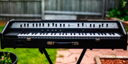

In [6]:
im = Image.open(dest)
im.to_thumb(128,128)

In [7]:
synth_types = 'keyboard','groovebox','modular'
path = Path('synthesizer')

In [8]:
if not path.exists():
    path.mkdir()
    for o in synth_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} synthesizer')
        download_images(dest, urls=results)

In [9]:
fns = get_image_files(path)
fns

(#586) [Path('synthesizer/modular/1e96cd25-5d27-42ab-bae5-c640d1d14ff7.jpg'),Path('synthesizer/modular/fca31511-c8a1-4e64-ae60-c84fa380e851.jpg'),Path('synthesizer/modular/74731aac-8912-4707-af6e-00314c7f8afa.jpg'),Path('synthesizer/modular/c6c08e5a-2ce3-4bac-836b-db91889d34b3.png'),Path('synthesizer/modular/3d9e7fd0-9845-4cb5-b978-73f607fc096a.jpg'),Path('synthesizer/modular/5927ca5f-1808-4394-aff9-7b9963776cf0.jpg'),Path('synthesizer/modular/458898b3-9a2f-49c4-9f1e-e233d334cd30.jpg'),Path('synthesizer/modular/67f785a1-132c-459f-9e5c-611966613e74.jpg'),Path('synthesizer/modular/4c45d806-0865-41ee-8369-b7ed5e70468d.png'),Path('synthesizer/modular/dfe68e9d-ced5-42a6-bc5f-cc7567d4a5d7.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#9) [Path('synthesizer/modular/e8ded1f8-6e08-420c-979f-ed7f182f76e0.jpg'),Path('synthesizer/modular/877cff5a-23d6-45d2-9518-365d5dcd8561.jpg'),Path('synthesizer/modular/20755afa-3da5-4212-8e9b-4862f81c039c.jpg'),Path('synthesizer/keyboard/d9c9e6d9-012c-4806-9719-617d3e161932.jpg'),Path('synthesizer/keyboard/186ac5d0-4b5f-4531-8f25-d4849f4163a1.jpg'),Path('synthesizer/keyboard/59571240-646c-4199-aefb-9425cebbc2f6.jpg'),Path('synthesizer/groovebox/cc14f1c1-6275-4384-b29b-ae2adc69beac.jpg'),Path('synthesizer/groovebox/5e1b1bdd-0b2c-42ea-b729-e9ef4d0611f4.jpg'),Path('synthesizer/groovebox/2a3dabb1-143e-48a9-86fb-6e29f6f531bc.jpg')]

In [11]:
failed.map(Path.unlink);

In [12]:
!pip install nbdev
doc(verify_images)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 1.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.8 MB/s eta 0:00:00


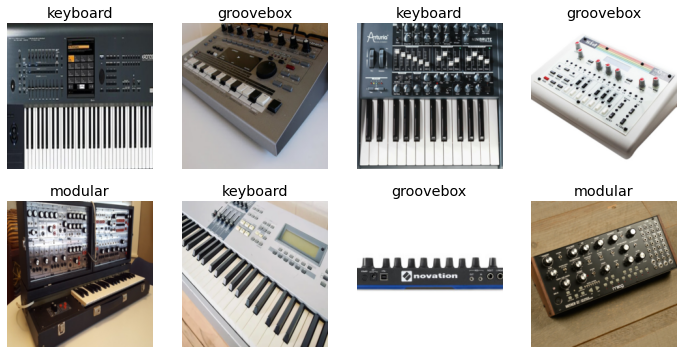

In [13]:
synths = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label)

synths2 = synths.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()) # preferred way to transform.
dls = synths2.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

# doc(dls.valid.show_batch)

In [14]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.631045,0.525563,0.243478,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.546053,0.448652,0.191304,00:16
1,0.455233,0.451561,0.173913,00:20
2,0.393949,0.449304,0.165217,00:18
3,0.335342,0.451822,0.156522,00:17


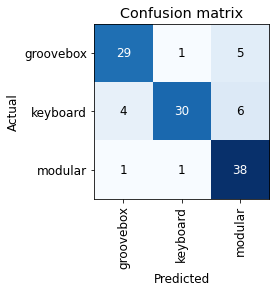

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

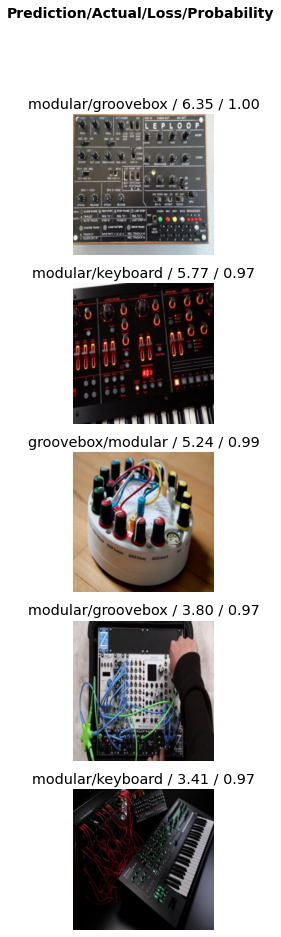

In [16]:
interp.plot_top_losses(5, nrows=5)

In [17]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [19]:
learn.export()

In [20]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [21]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict('images/synth.jpg')

('keyboard', TensorBase(1), TensorBase([3.4685e-05, 9.9968e-01, 2.8773e-04]))

In [22]:
learn_inf.dls.vocab


['groovebox', 'keyboard', 'modular']

In [23]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [25]:
img = PILImage.create(btn_upload.data[-1])

In [26]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [27]:
pred,pred_idx,probs = learn_inf.predict(img)


In [28]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: groovebox; Probability: 0.9975')

In [29]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [30]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [31]:

#hide_output
VBox([widgets.Label('Select your synth!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [32]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: jupyter-core
    Found existing installation: jupyter-core 4.10.0
    Uninstalling jupyter-core-4.10.0:
      Successfully uninstalled jupyter-core-4.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
Enabling: voila
- Writing config: /opt/conda/etc/jupyter
    - Validating...
      voila 0.4.0 OK
